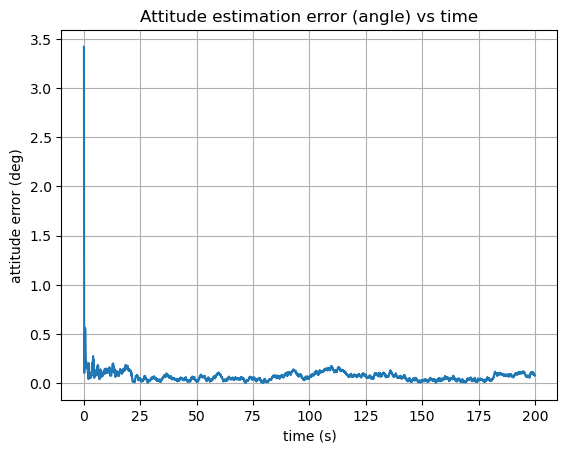

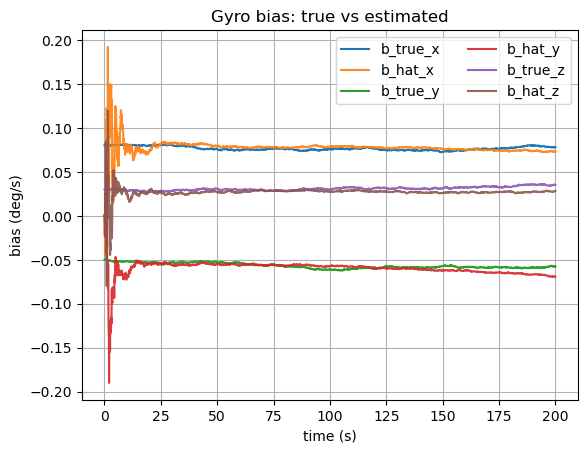

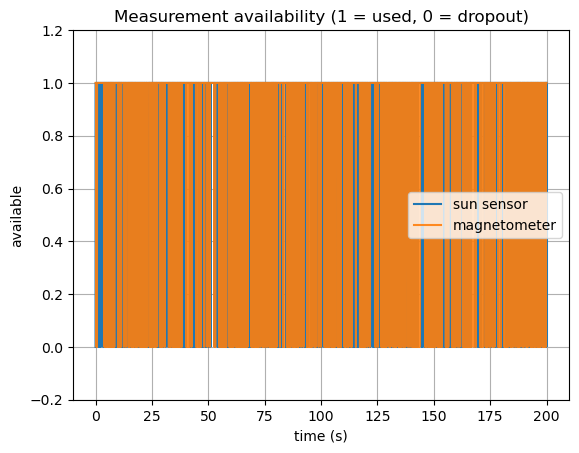

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Quaternion utilities
# -----------------------
def q_norm(q):
    return q / np.linalg.norm(q)

def q_mul(q1, q2):
    # Hamilton product, scalar-first convention: q = [qw, qx, qy, qz]
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

def q_conj(q):
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

def q_to_R(q):
    # rotation matrix from inertial to body
    q = q_norm(q)
    w, x, y, z = q
    R = np.array([
        [1-2*(y*y+z*z),   2*(x*y - z*w), 2*(x*z + y*w)],
        [2*(x*y + z*w),   1-2*(x*x+z*z), 2*(y*z - x*w)],
        [2*(x*z - y*w),   2*(y*z + x*w), 1-2*(x*x+y*y)]
    ])
    return R

def skew(v):
    vx, vy, vz = v
    return np.array([
        [0, -vz,  vy],
        [vz,  0, -vx],
        [-vy, vx,  0]
    ])

def small_angle_quat(dtheta):
    # dtheta is a small rotation vector (rad)
    # delta_q ≈ [1, 0.5*dtheta]
    return q_norm(np.array([1.0, 0.5*dtheta[0], 0.5*dtheta[1], 0.5*dtheta[2]]))

# -----------------------
# Rigid body truth model
# -----------------------
def omega_dot(J, omega, tau):
    # Euler rigid-body equation: J*w_dot = tau - w x (J w)
    return np.linalg.solve(J, tau - np.cross(omega, J @ omega))

def quat_dot(q, omega):
    # q_dot = 0.5 * q ⊗ [0, omega]
    w = np.array([0.0, omega[0], omega[1], omega[2]])
    return 0.5 * q_mul(q, w)

def rk4_step_attitude(J, q, omega, tau, dt):
    # one RK4 step on (q, omega)
    def f(state):
        q_ = state[:4]
        w_ = state[4:]
        dq = quat_dot(q_, w_)
        dw = omega_dot(J, w_, tau)
        return np.hstack([dq, dw])

    x0 = np.hstack([q, omega])
    k1 = f(x0)
    k2 = f(x0 + 0.5*dt*k1)
    k3 = f(x0 + 0.5*dt*k2)
    k4 = f(x0 + dt*k3)
    x1 = x0 + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    q1 = q_norm(x1[:4])
    w1 = x1[4:]
    return q1, w1

# -----------------------
# Measurement model: body vector measurements
# -----------------------
def normalize(v):
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def body_vector_measurement(q, v_inertial):
    # predicted body-frame measurement of inertial vector v_i
    R = q_to_R(q)           # inertial -> body
    return normalize(R @ v_inertial)

# MEKF measurement Jacobian for unit vector measurement:
# y = normalize(R(q) v_i)
# Using small-angle error: v_b ≈ v_b_pred - [v_b_pred]_x dtheta
def H_vec(vb_pred):
    return -skew(vb_pred)

# -----------------------
# MEKF
# State error: x = [dtheta (3), b (3)]
# Nominal: q_hat, b_hat
# -----------------------
def run_attitude_mekf():
    np.random.seed(3)

    # --- sim settings
    dt = 0.05
    T  = 200.0
    N  = int(T/dt)

    # --- inertia (kg*m^2), a bit asymmetric so it's not too "perfect"
    J = np.diag([0.12, 0.10, 0.08])

    # --- truth initial conditions
    q_true = q_norm(np.array([1.0, 0.0, 0.0, 0.0]))
    w_true = np.deg2rad(np.array([0.4, -0.2, 0.3]))  # rad/s

    # small constant disturbance torque (N*m)
    tau = np.array([2e-6, -1e-6, 1.5e-6])

    # --- inertial reference vectors (known)
    sun_i = normalize(np.array([1.0, 0.2, -0.1]))
    mag_i = normalize(np.array([-0.3, 0.9, 0.25]))

    # --- sensor noise levels
    sigma_gyro = np.deg2rad(0.02)    # rad/s noise
    sigma_sun  = np.deg2rad(0.3)     # rad (approx; we'll model as vector noise)
    sigma_mag  = np.deg2rad(0.8)     # rad

    # --- gyro bias truth (rad/s)
    b_true = np.deg2rad(np.array([0.08, -0.05, 0.03]))

    # bias random walk strength (rad/s^2)  (tune to show convergence)
    sigma_b_rw = np.deg2rad(0.0005)

    # --- filter initial guess
    q_hat = q_norm(q_mul(small_angle_quat(np.deg2rad([5.0, -3.0, 4.0])), q_true))
    b_hat = np.deg2rad(np.array([0.0, 0.0, 0.0]))

    P = np.diag([
        np.deg2rad(5.0)**2, np.deg2rad(5.0)**2, np.deg2rad(5.0)**2,   # attitude error
        np.deg2rad(0.2)**2, np.deg2rad(0.2)**2, np.deg2rad(0.2)**2    # bias error
    ])

    # process noise covariance (discrete-ish)
    # dtheta_dot ≈ -[w]_x dtheta - db + gyro_noise
    # b_dot = bias_rw
    Q = np.diag([
        (sigma_gyro**2)*dt, (sigma_gyro**2)*dt, (sigma_gyro**2)*dt,
        (sigma_b_rw**2)*dt, (sigma_b_rw**2)*dt, (sigma_b_rw**2)*dt
    ])

    # measurement noise covariances (vector measurement, 3 components)
    R_sun = (sigma_sun**2) * np.eye(3)
    R_mag = (sigma_mag**2) * np.eye(3)

    # dropouts
    p_drop_sun = 0.15
    p_drop_mag = 0.10

    # storage
    t = np.arange(N) * dt
    att_err_deg = np.zeros(N)
    b_err = np.zeros((N, 3))
    b_true_hist = np.zeros((N, 3))
    b_hat_hist  = np.zeros((N, 3))
    used_sun = np.zeros(N, dtype=bool)
    used_mag = np.zeros(N, dtype=bool)

    for k in range(N):
        # ---- truth propagation
        q_true, w_true = rk4_step_attitude(J, q_true, w_true, tau, dt)

        # bias truth random walk
        b_true = b_true + np.random.randn(3) * sigma_b_rw * np.sqrt(dt)

        # ---- sensors
        w_meas = w_true + b_true + np.random.randn(3) * sigma_gyro

        sun_meas = None
        mag_meas = None

        if np.random.rand() > p_drop_sun:
            vb = body_vector_measurement(q_true, sun_i)
            sun_meas = normalize(vb + np.random.randn(3) * sigma_sun)
            used_sun[k] = True

        if np.random.rand() > p_drop_mag:
            vb = body_vector_measurement(q_true, mag_i)
            mag_meas = normalize(vb + np.random.randn(3) * sigma_mag)
            used_mag[k] = True

        # ---- MEKF predict (propagate nominal quaternion using gyro - bias)
        w_hat = w_meas - b_hat

        # simple quaternion integration (RK4 on quaternion only)
        # (truth uses full rigid-body; filter uses gyro integration)
        def qdot(q):
            return quat_dot(q, w_hat)

        k1 = qdot(q_hat)
        k2 = qdot(q_norm(q_hat + 0.5*dt*k1))
        k3 = qdot(q_norm(q_hat + 0.5*dt*k2))
        k4 = qdot(q_norm(q_hat + dt*k3))
        q_hat = q_norm(q_hat + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4))

        # Error-state dynamics Jacobian F (discrete approx)
        F = np.eye(6)
        F[0:3, 0:3] += -skew(w_hat) * dt
        F[0:3, 3:6] += -np.eye(3) * dt
        # bias random walk already in Q

        P = F @ P @ F.T + Q

        # ---- MEKF update function (vector measurement)
        def update_with_vec(z_meas, v_i, Rm):
            nonlocal q_hat, b_hat, P

            vb_pred = body_vector_measurement(q_hat, v_i)   # predicted body vector
            r = z_meas - vb_pred                             # residual in R^3

            H = np.zeros((3, 6))
            H[:, 0:3] = H_vec(vb_pred)                       # sensitivity to dtheta
            # no direct bias term in static vector measurement

            S = H @ P @ H.T + Rm
            K = P @ H.T @ np.linalg.inv(S)

            dx = K @ r
            dtheta = dx[0:3]
            db = dx[3:6]

            # inject corrections into nominal states
            dq = small_angle_quat(dtheta)
            q_hat = q_norm(q_mul(dq, q_hat))
            b_hat = b_hat + db

            P = (np.eye(6) - K @ H) @ P

        if sun_meas is not None:
            update_with_vec(sun_meas, sun_i, R_sun)

        if mag_meas is not None:
            update_with_vec(mag_meas, mag_i, R_mag)

        # ---- logging
        # attitude error angle between q_true and q_hat
        dq = q_mul(q_hat, q_conj(q_true))  # q_hat * q_true^{-1}
        dq = q_norm(dq)
        ang = 2.0 * np.arccos(np.clip(np.abs(dq[0]), 0.0, 1.0))  # shortest angle
        att_err_deg[k] = np.rad2deg(ang)

        b_true_hist[k] = b_true
        b_hat_hist[k]  = b_hat
        b_err[k] = (b_hat - b_true)

    # -----------------------
    # Plots (deliverables)
    # -----------------------
    plt.figure()
    plt.plot(t, att_err_deg)
    plt.grid(True)
    plt.title("Attitude estimation error (angle) vs time")
    plt.xlabel("time (s)")
    plt.ylabel("attitude error (deg)")

    plt.figure()
    plt.plot(t, np.rad2deg(b_true_hist[:, 0]), label="b_true_x")
    plt.plot(t, np.rad2deg(b_hat_hist[:, 0]),  label="b_hat_x", alpha=0.9)
    plt.plot(t, np.rad2deg(b_true_hist[:, 1]), label="b_true_y")
    plt.plot(t, np.rad2deg(b_hat_hist[:, 1]),  label="b_hat_y", alpha=0.9)
    plt.plot(t, np.rad2deg(b_true_hist[:, 2]), label="b_true_z")
    plt.plot(t, np.rad2deg(b_hat_hist[:, 2]),  label="b_hat_z", alpha=0.9)
    plt.grid(True)
    plt.title("Gyro bias: true vs estimated")
    plt.xlabel("time (s)")
    plt.ylabel("bias (deg/s)")
    plt.legend(ncol=2)

    plt.figure()
    plt.plot(t, used_sun.astype(int), label="sun sensor")
    plt.plot(t, used_mag.astype(int), label="magnetometer", alpha=0.9)
    plt.ylim(-0.2, 1.2)
    plt.grid(True)
    plt.title("Measurement availability (1 = used, 0 = dropout)")
    plt.xlabel("time (s)")
    plt.ylabel("available")
    plt.legend()

    plt.show()

if __name__ == "__main__":
    run_attitude_mekf()